# Pose Detection
This notebook contains pre-processing methods for pose anomaly detection.

The notebook was tested on Ubuntu 18.04, CUDA 9. cuDNN 7.1.2 and PyTorch 0.4.1

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch

In [2]:
video_directory = "video"

## Single video loading and frame extraction
This part contains video processing methods

In [3]:
# video_file_name = os.path.join("arrest", "Arrest005_x264.mp4")
# video_file_name = os.path.join("arrest", "Arrest001_x264.mp4")
video_file_name = os.path.join("normal", "Normal_Videos045_x264.mp4")

file_name = os.path.join(video_directory, video_file_name)

video_capture = cv2.VideoCapture(file_name)

In [4]:
"""
Processes all video frames and applies a given function on each frame with its own arguments
"""
def process_frames(video, fun, *args):
    while video.isOpened():
        frame = get_next_frame(video)
        fun(frame, *args)
    video.release()

"""
Retrieves next video frame
"""
def get_next_frame(video, convert_bgr=True):
    if video.isOpened():
        result, frame = video.read()
        if result and frame is not None:
            if convert_bgr:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            return frame
    return None

"""
Sets current video frame to a given position
"""
def set_video_position(video, position):
    video.set(cv2.CAP_PROP_POS_FRAMES, position)

"""
Resets video position to the first frame
"""
def reset_video_position(video):
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)

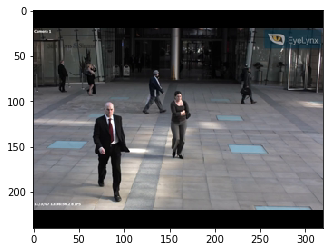

In [5]:
# start at frame 0
# reset_video_position(video_capture)
# set_video_position(video_capture, 640)  # arrest01
set_video_position(video_capture, 160)  # normal45


# get first frame
# image = get_next_frame(video_capture, False)  # BGR
image = get_next_frame(video_capture)  # RGB

if image is not None:
    plt.imshow(image)

# Human Pose Estimation in PyTorch
This part runs a pretrained PyTorch model for extracting pose information on a single video frame

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model_directory = os.path.join("pose.pytorch", "pose-coco")
model_name = "pose_resnet_50_384x288.pth.tar"
# model_name = "pose_resnet_101_384x288.pth.tar"
# model_name = "pose_resnet_152_384x288.pth.tar"

# HEIGHT, WIDTH = 192, 256
HEIGHT, WIDTH = 288, 384

file_name = os.path.join(model_directory, model_name)

cuda:0


## Image preprocessing

In [8]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

to_tensor = transforms.Compose([transforms.ToTensor(), transforms.Normalize(imagenet_mean, imagenet_std)])

## Pose Model
The following section loads a MSCOCO pretrained pose model with ImageNet statistical properties

In [9]:
sys.path.append('lib')
import lib

from lib.models.pose_resnet import get_pose_net
from lib.core.config import config
from lib.core.config import update_config


# update_config('experiments/coco/resnet152/384x288_d256x3_adam_lr1e-3.yaml')
update_config('experiments/coco/resnet50/384x288_d256x3_adam_lr1e-3.yaml')

config.TEST.FLIP_TEST = True
# config.TEST.MODEL_FILE = 'pose.pytorch/pose-coco/pose_resnet_152_384x288.pth.tar'
config.TEST.MODEL_FILE = 'pose.pytorch/pose-coco/pose_resnet_50_384x288.pth.tar'

model = get_pose_net(config, is_train=False)
print(config.TEST.MODEL_FILE)
model.load_state_dict(torch.load(config.TEST.MODEL_FILE))
model.eval()

pose.pytorch/pose-coco/pose_resnet_50_384x288.pth.tar


PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bi

## Inferencing pose from an image
Here the pose is inferred from an image using the pose model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


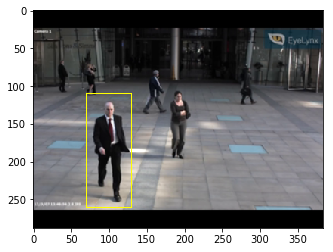

In [10]:
inference_image = cv2.resize(image, (WIDTH, HEIGHT))
inference_image = inference_image.astype(np.float32) / 255.0
# object detection box
# box = [120, 50, 60, 130]  # arrest01
box = [70, 110, 60, 150]  # normal45

show_image = inference_image.copy()
cv2.rectangle(show_image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 255, 0), 1)

plt.imshow(show_image)

In [11]:
from lib.utils.transforms import *

def _box2cs(box, width, height):
    x, y, w, h = box[:4]
    return _xywh2cs(x, y, w, h, width, height)

def _xywh2cs(x, y, w, h, width, height):
    center = np.zeros((2), dtype=np.float32)
    center[0] = x + w * 0.5
    center[1] = y + h * 0.5
    
    aspect_ratio = float(width) / float(height)
    pixel_std = 200
    
#     print(w, h, width, height, aspect_ratio)

    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
#         print(w, h)
    scale = np.array(
        [w * 1.0 / pixel_std, h * 1.0 / pixel_std],
        dtype=np.float32)
    if center[0] != -1:
        scale = scale * 1.25

    return center, scale

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Joint coordinates:
(104, 136), (104, 136), (103, 136), (103, 136), (95, 136), (108, 147), (86, 147), (127, 184), (82, 168), (113, 183), (91, 183), (108, 183), (96, 183), (109, 206), (92, 203), (109, 236), (88, 219)


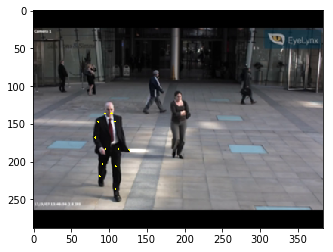

In [12]:
from core.inference import get_final_preds
from core.inference import get_max_preds

def get_poses(image, verbose=False):
    center, scale = _box2cs(box, image.shape[1], image.shape[0])
    rotation = 0
    
    trans = get_affine_transform(center, scale, rotation, config.MODEL.IMAGE_SIZE[::-1])
#     print(trans)
    
    input_image = image.copy()
    input_image = cv2.warpAffine(
                                 image,
                                 trans,
                                 (int(config.MODEL.IMAGE_SIZE[1]), int(config.MODEL.IMAGE_SIZE[0])),
                                 flags=cv2.INTER_LINEAR
                                )

#     plt.imshow(input_image)

    tensor = to_tensor(input_image).unsqueeze(0)
    with torch.no_grad():
#         predictions = model.forward(tensor)
#         predictions = np.array(predictions.detach().squeeze())
        output = model(tensor)
        predictions, maxvals = get_final_preds(config, output.clone().cpu().numpy(), np.asarray([center]), np.asarray([scale]))
#         predictions, maxvals = get_max_preds(output.clone().cpu().numpy())
    if verbose:
        print(input_image.shape)
        print(result.shape)
        print(result)
    return predictions, trans, input_image

def get_point(mat):
    height, width = mat.shape
    mat = mat.reshape(-1)
    idx = np.argmax(mat)
    return idx % width, idx // width

def get_inverted_affine_transform(trans):
    result = np.zeros_like(trans)
    result[:, :2] = np.linalg.inv(trans[:, :2])
    result[:, 2] = -trans[:, 2]
    return result

def display_poses(image, poses, trans):
#     image = cv2.resize(image, (64, 64))
#     print(image.shape)
    inverted_trans = get_inverted_affine_transform(trans)
#     print(trans)
#     print(inverted_trans)
    print("Joint coordinates:")
    joints = []
    for mat in poses[0]:
#         x, y = get_point(mat)
        x, y = mat[0], mat[1]
#         x, y = inverted_trans[:, :2].dot(np.array((x, y)).T)
#         x, y = inverted_trans[:, 2] + np.array((x, y)).T
        x, y = int(x), int(y)
        cv2.circle(image, center=(x, y), thickness=-1, color=(255, 255, 0), radius=1)
        joints.append((x, y))
    print(", ".join(str(x) for x in joints))
    plt.imshow(image)
    
# poses, trans, input_image = get_poses(inference_image, True)
poses, trans, input_image = get_poses(inference_image)
display_poses(inference_image, poses, trans)
# display_poses(input_image, poses, trans)

# Pose Estimation in Videos (Detect & Track) in Caffe2
To be added (https://github.com/miracle-fmh/DetectAndTrack)